## Identifying Duplicate Questions
여기에서는 매달 10억명의 사람들이 이용하는 Quora 사이트의 데이터를 살펴 볼것이다. 많은 사람들이 이용하는 만큼 수 많은 종류의 질문들이 매일매일 만들어진다. Quora에서는 새로 생성되는 질문이 이미 존재하는 것인지 아닌지를 판단하는 것이 매우 중요하다.
이 노트북에서는 데이터를 가지고 질문의 중복 여부를 예측하는 과정을 살펴보자.

In [4]:
# import
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()


In [7]:
print ('# File sized')
for f in os.listdir('../Quora Question Pairs'):
    if 'csv' in f:
        print(f.ljust(30) + str(round(os.path.getsize('../Quora Question Pairs/' + f) / 1000000, 2)) + 'MB')

# File sized
test.csv                      314.02MB
train.csv                     63.4MB


raw data를 살펴보면 전체 데이터는 test와 train용 두가지 형태로만 존재하고 test set의 용량이 training set의 용량보다 더 크다는 것을 알 수있다.

## Set training data

In [46]:
df_train = pd.read_csv('../Quora Question Pairs/train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


data에 column에 어떠한 것들이 있는지 살펴보자.
- id: 일반적인 rowID
- qid{1, 2}: 각각 질문 쌍에 부여된 고유의 ID
- question{1, 2}: text형태로 된 실제 질문 내용
- is_duplicate: 두가지 질문의 중복 여부


Total number of question pairs for training:404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



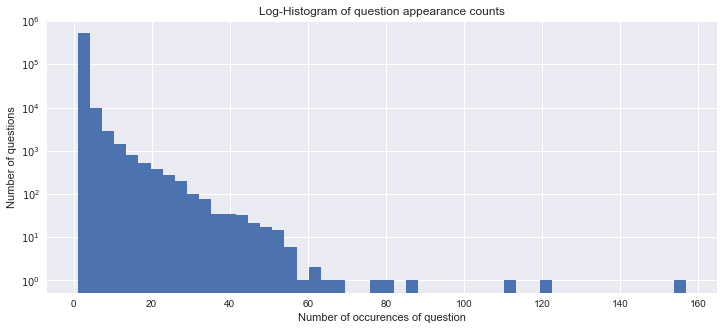

In [12]:
print('Total number of question pairs for training:{}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100,2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12,5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

위의 그래프를 살펴보면 대부분의 질문들이 몇번만 나타난다는 것을 알수있다. 오직 몇몇의 질문들만이 빈도수가 높은 것을 알수있다. 맨 오른쪽 부분에 위치한 데이터를 보면 160번이나 나타나는 것을 볼수있는데 다른 질문들과 비교해 봤을때 이정도는 아웃라이어라고 여길 수있다.

Datasets의 다른 부분을 살펴보면 약 37%정도는 target값으로 1을 가지고있다. 우리가 여기서 LogLoss metric을 사용할 것이기 때문에 예측치를 평가하기 위해서 label 값들의 평균값을 구해야한다.

In [34]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean()
print('Predicted score: ', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

df_test = pd.read_csv('../Quora Question Pairs/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)
sub.head()

Predicted score:  0.658527383984


,is_duplicate,test_id
0,0.369198,0
1,0.369198,1
2,0.369198,2
3,0.369198,3
4,0.369198,4


이정도만으로 LeaderBoard(LB)에 제출해보니 0.55의 score을 얻었다. 우리의 Predicted score와 LB의 score가 많이 다른 이유는 우리가 가지고 있는 것과 LB가 가지고 있는 values의 분포가 상당히 다르다는 것을 알 수 있다. 
이제 test data들은 어떠한 모습인지 통계적으로 살펴보자. 

## Test set

In [35]:
df_test = pd.read_csv('../Quora Question Pairs/test.csv')
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [37]:
print('Total number of question pairs for testing: {}'.format(len(df_test)))

Total number of question pairs for testing: 2345796


여기에서 특별한점은 없어보인다. Test set에서는 각 질문쌍에 주어졌던  id 값이 없다.
데이터의 총 row값은 230만개 정도이다. data page에 따르면 각 row에 있는 대부분의 질문들은 데이터 양을 늘이고 불필요한 hand-labelling을 없애기위해 자동 생성된 질문들이다. 이것은 진짜 질문이 속해 있는 row들은 매우 적을수도 있다는 것을 나타낸다.

## Text analysis
첫번째로, 우리가 찾는것의 histogram를 그려보자. test set에는 자동 생성된 질문들이 많기 때문에 대부분의 분석은 training set에서 진행된다.

mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.62 max-train 1169.00 max-test 1176.00


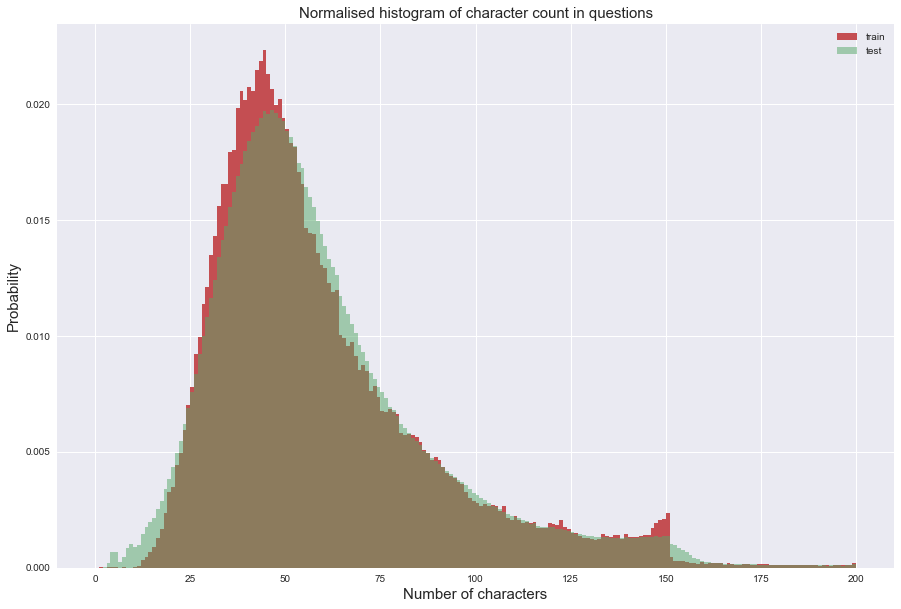

In [45]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0,200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0,200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title("Normalised histogram of character count in questions", fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

그래프를 그려보니 대부분의 characters가 15개에서 150개 사이임을 알수있다. 자세히보면 train set와 test set의 분포가 조금 다른것을 알수있는데 test set이 좀더 부드러운 형태의 분포를 보인다는 것을 알수있다. 
특이한 점은 train set의 경우 character의 수가 150에서 급격하게 줄어드는 것을 볼수있다. 이것을 통해 Quora의 질문 크기에 제한이 있을것이라는 생각을 해볼수있다.
이 그래프에서 character 개수 제한을 200개로 하였는데 원래 데이터에서는 1200개 까지 허용된다. 하지만 200개 내외에 대부분의 데이터가 포함되기 때문에 큰 문제는 없어 보인다.

이번에는 word를 기준으로 distribution plot을 그려보자. 여기서는 띄어쓰기 기준인 word를 사용한다.  

mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


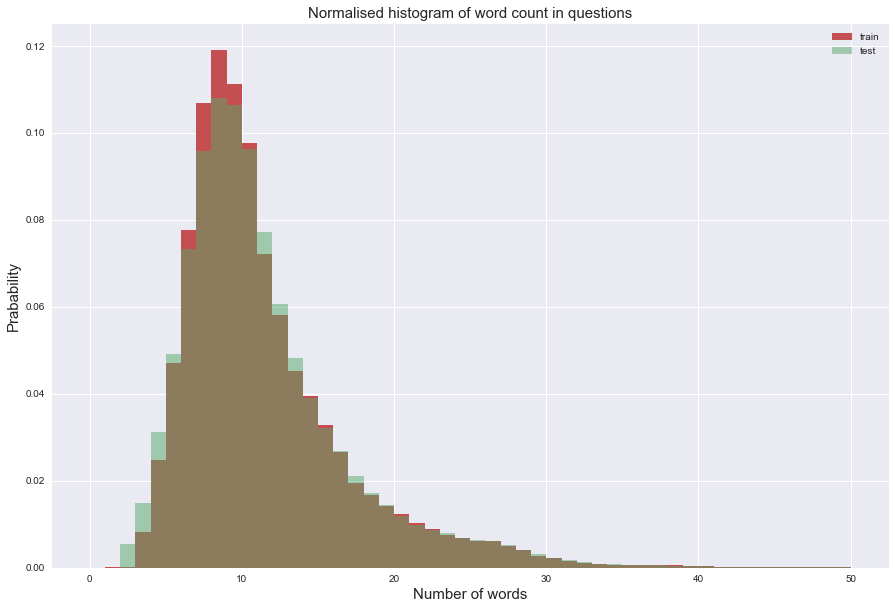

In [48]:
dist_train = train_qs.apply(lambda x:len(x.split(' ')))
dist_test = test_qs.apply(lambda x:len(x.split(' ')))

plt.figure(figsize=(15,10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5 ,label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Prabability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max())) 

word의 distribution도 character와 비슷한 분포를 보이는 것을 알수있다. 대부분의 word 가 10개 내외로 형성되는것을 알수있다. 여기에서도 test의 분포가 더 부드러운 분포를 보인다는 것을 알수 있지만 두 distribution이 상당히 비슷하다는 것을 알수있다.
다음으로는 어떠한 단어가 가장 많이 나왔는지 살펴보도록 하자.

(-0.5, 1439.5, 1079.5, -0.5)

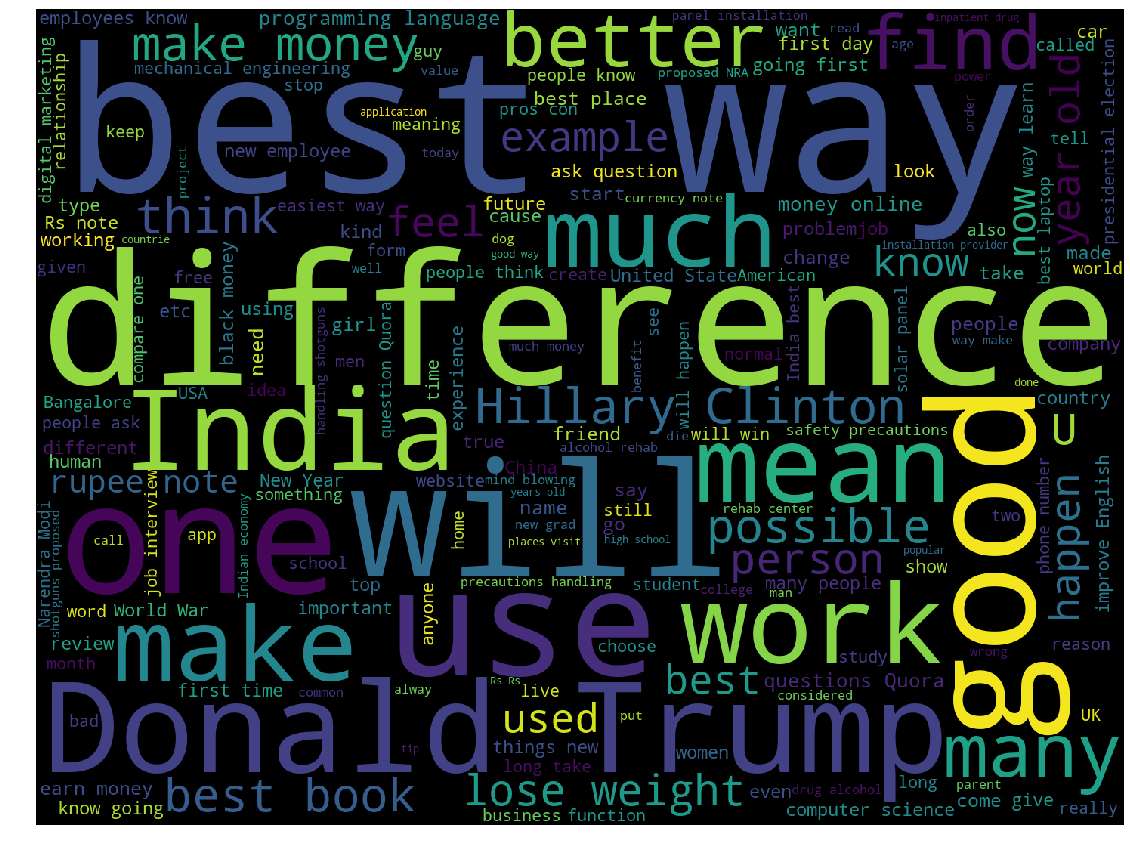

In [50]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

## Semantic Analysis

이제 사람들이 질문을 할때 어떠한 구두점을 사용해서 질문을 하는지 살펴보자.

In [51]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


## Initial Feature Analysis
본격적으로 분류 모델을 만들기 전에 nltk의 stopwords에 속해있는 단어를 제외한 단어들이 얼마나 큰 영향력을 가졌는지 살펴보도록 하자.

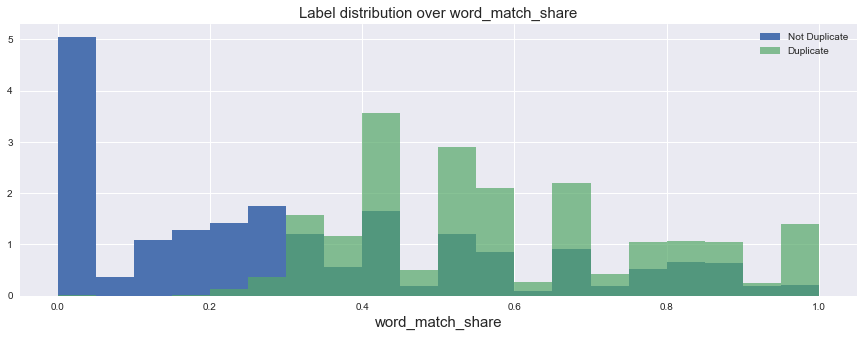

In [57]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15,5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

위의 그래프를 살펴 보면 특정 단어들로 not duplicate와 duplicate를 어느 정도 구분할수 있을것이라는 것을 알수있다. 하지만 두 범주가 겹치는 부분이 상당 부분있기 때문에 완전히 좋은 방법이라고는 볼 수 없다.

## TF-IDF
이제 TF-IDF 기법을 사용하여 이 feature의 좀 더 발전시켜 보자. 이 기법은 특정 단어가 나타나는 빈도를 파악하여 단어 마다 특정 가중치를 부여하는 방법이다. 만약에 다른 질문에서 흔하게 사용되지 않는 단어가 사용되었다면 흔하게 사용되는 단어보다 더 많은 영향력을 가졌을 것이라고 판단 할수있다.

In [77]:
from collections import Counter
# 여기서는 만약 특정단어가 오직 한번만 나타난다면 이것을 전적으로 무시한다.(오타일수도 있기 때문에)
# 밑의 eps는 나타나는 빈도가 너무 적은 단어의 영향력을 줄어주는 역할을 한다.
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}


In [65]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key = lambda x:x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key = lambda x:x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('シ', 9.998000399920016e-05),
 ('し?', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05),
 ('109?', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('fulfill?', 9.998000399920016e-05)]

In [66]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0  or len(q2words) == 0:
        return 0
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


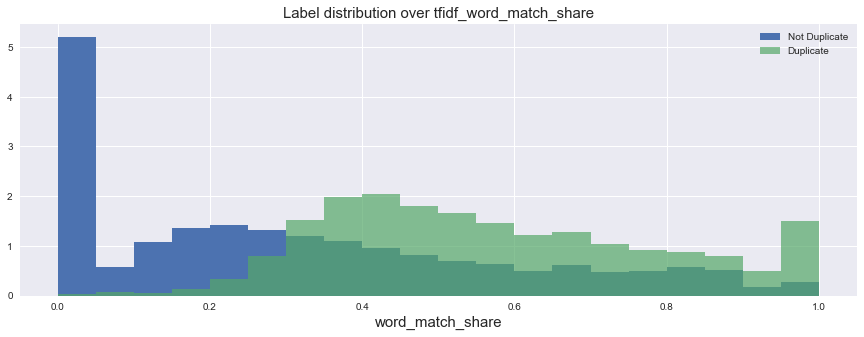

In [69]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)


In [70]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.780553200628
   TFIDF AUC: 0.77056466105


AUC 살펴보니 TFIDF를 적용한 결과가 오히려 더 낮은것을 알수있다. 
결과가 떨어진것은 아쉽지만 이제 이 두가지 features(Stopwords and TFIDF)를 결합하여 예측모델로 만들것이다. 이후에는 XGBoost를 이용하여 분류 모델을 만들것이다.

## Rebalancing the Data
다음 단계로 진행하기 전에 training set와 test set의 positive rate가 다르기 때문에 XGBoost가 받을 Data를 rebalancing하는 과정이 필요하다. Training set의 positive rate를 17%로 조정해주면 XGBoost가 더 좋은 확률값을 가질수 있고 더 나은 결과값을 가질수있다. 

In [71]:
# 먼저 trainning, testing 데이터를 만든다.
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

y_train = df_train['is_duplicate'].values

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


In [74]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [75]:
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

## XGBoost
이제 우리의 data를 XGBoost에 적용하고 LB score를 살펴보자

In [76]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.683189	valid-logloss:0.683238
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.602041	valid-logloss:0.602515
[20]	train-logloss:0.544863	valid-logloss:0.545663
[30]	train-logloss:0.503151	valid-logloss:0.504194
[40]	train-logloss:0.471989	valid-logloss:0.473231
[50]	train-logloss:0.448341	valid-logloss:0.449746
[60]	train-logloss:0.430164	valid-logloss:0.431706
[70]	train-logloss:0.416072	valid-logloss:0.417726
[80]	train-logloss:0.405012	valid-logloss:0.406775
[90]	train-logloss:0.396327	valid-logloss:0.398177
[100]	train-logloss:0.389488	valid-logloss:0.391404
[110]	train-logloss:0.384071	valid-logloss:0.386038
[120]	train-logloss:0.379786	valid-logloss:0.381792
[130]	train-logloss:0.376375	valid-logloss:0.378414
[140]	train-logloss:0.373661	valid-logloss:0.375724
[150]	train-logloss:0.371482	valid-logloss:0.373567
[160]	train-logloss:0.369728

In [78]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)

0.35460 LB score를 기록하였다. 초기 LB score 0.55보다 상당히 좋아진 것을 확인 할 수있다.